In [1]:
# !pip install rasterio -q

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import rasterio
from tqdm.notebook import tqdm

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

### Data Loading and Exploration

In [3]:
DATA_PATH = r'C:\Users\janen\Desktop\byte sized'

train_dataset = pd.read_csv(os.path.join(DATA_PATH, 'TrainDataset.csv'))
test_dataset = pd.read_csv(os.path.join(DATA_PATH, 'TestDataset.csv'))

train_images_path = os.path.join(DATA_PATH, 'S2Images/train')
test_images_path = os.path.join(DATA_PATH, 'S2Images/test')

In [4]:
# Lets drop null tifpaths
train_dataset = train_dataset.dropna(subset=['tifPath'])
test_dataset = test_dataset.dropna(subset=['tifPath'])

print(f"Train dataset shape: {train_dataset.shape}")
print(f"Test dataset shape: {test_dataset.shape}")

Train dataset shape: (7433, 6)
Test dataset shape: (2201, 4)


In [5]:
# Replace the image paths
train_dataset['tifPath'] = train_dataset['tifPath'].apply(lambda x: os.path.join(train_images_path, os.path.basename(x)))
test_dataset['tifPath'] = test_dataset['tifPath'].apply(lambda x: os.path.join(test_images_path, os.path.basename(x)))

# View train data
train_dataset.head()

,ID,year,month,tifPath,Target,class
0,ID_h14T0B_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
1,ID_KbyKOr_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
2,ID_t4Tmmn_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
3,ID_yipWoC_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
4,ID_XKiksa_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3


In [6]:
# View test data
test_dataset.head()

,ID,year,month,tifPath
0,ID_731818_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tes...
1,ID_790093_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tes...
2,ID_931033_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tes...
3,ID_079024_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tes...
4,ID_691532_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tes...


### Data Preprocessing

In [7]:
print(f"Train dataset shape: {train_dataset.shape}")
print(f"Test dataset shape: {test_dataset.shape}")

Train dataset shape: (7433, 6)
Test dataset shape: (2201, 4)


In [8]:
train_dataset.head()

,ID,year,month,tifPath,Target,class
0,ID_h14T0B_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
1,ID_KbyKOr_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
2,ID_t4Tmmn_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
3,ID_yipWoC_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3
4,ID_XKiksa_Jan,2024,Jan,C:\Users\janen\Desktop\byte sized\S2Images/tra...,Rubber,3


In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial


def process_single_file(row, all_bands, is_train=False):

    tif_path = row["tifPath"]
    if pd.isna(tif_path) or not os.path.exists(tif_path):
        print(f"Missing or invalid path: {tif_path}")
        return None

    try:
        with rasterio.open(tif_path) as src:
            band_means = {}
            for i in range(1, src.count + 1):
                if i-1 < len(all_bands):
                    band_name = all_bands[i - 1]
                    band_data = src.read(i).astype('float32')
                    band_data[band_data == 0] = np.nan
                    mean_val = np.nanmean(band_data)
                    band_means[f"{band_name}"] = mean_val

        row_data = {
            "ID": row["ID"],
            "month": row["month"] if "month" in row else None,
            **band_means
        }

        if is_train:
            if "Target" in row:
                row_data["Crop"] = row["Target"]
            if "class" in row:
                row_data["class"] = row["class"]

        return row_data

    except Exception as e:
        print(f"Error processing {tif_path}: {e}")
        return None

def extract_sentinel2_features(df: pd.DataFrame, data_path: str, output_filename: str, is_train: bool = False, workers: int = 4) -> pd.DataFrame:

    ALL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

    # Create a partial function with fixed parameters
    process_func = partial(process_single_file, all_bands=ALL_BANDS, is_train=is_train)

    features = []

    print(f"Processing {len(df)} files using {workers} parallel workers...")

    with ThreadPoolExecutor(max_workers=workers) as executor:

        future_to_row = {executor.submit(process_func, row): idx for idx, row in df.iterrows()}

        for future in tqdm(as_completed(future_to_row), total=len(future_to_row), desc="Extracting Sentinel-2 features"):
            result = future.result()
            if result:
                features.append(result)

    features_df = pd.DataFrame(features)

    # Calculate success rate
    success_rate = len(features_df) / len(df) * 100
    print(f"Successfully processed {len(features_df)} out of {len(df)} files ({success_rate:.1f}%)")

    # Save to CSV
    os.makedirs(data_path, exist_ok=True)
    output_path = os.path.join(data_path, output_filename)
    features_df.to_csv(output_path, index=False)
    print(f"Saved features to {output_path}")

    return features_df

# Lets save the features in the drive
# drive_path = '/content/drive/MyDrive/Zindi/Computer-Vision/Byte-Sized-Agriculture-Challenge'
train_features_path = os.path.join(DATA_PATH, 'train_features.csv')
test_features_path = os.path.join(DATA_PATH, 'test_features.csv')

train_features_df = extract_sentinel2_features(
        train_dataset,
        data_path=train_images_path,
        output_filename=train_features_path,
        is_train=True,
        workers=4
    )

test_features_df = extract_sentinel2_features(
        test_dataset,
        data_path=test_images_path,
        output_filename=test_features_path,
        is_train=False,
        workers=4
    )

Processing 7433 files using 4 parallel workers...


Extracting Sentinel-2 features:   0%|          | 0/7433 [00:00<?, ?it/s]

Successfully processed 7433 out of 7433 files (100.0%)
Saved features to C:\Users\janen\Desktop\byte sized\train_features.csv
Processing 2201 files using 4 parallel workers...


Extracting Sentinel-2 features:   0%|          | 0/2201 [00:00<?, ?it/s]

Successfully processed 2201 out of 2201 files (100.0%)
Saved features to C:\Users\janen\Desktop\byte sized\test_features.csv


In [10]:
train_features_df = pd.read_csv(train_features_path)
test_features_df = pd.read_csv(test_features_path)

In [11]:
# Lets reshuffle the data to ensure the model sees a balanced mix of classes and features during training.
# This is important before splitting into training and validation sets, or when using k-fold cross-validation.
# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
# train_df.head()

In [12]:
train_features_df.head()

,ID,month,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,Crop,class
0,ID_b7J6Nq_Jan,Jan,4067.8674,3994.5237,3993.2756,4147.0796,4257.1520,5011.0293,5516.1895,5199.0415,5904.8780,1767.0850,4898.5127,3648.9010,Rubber,3
1,ID_ZUfp59_Jan,Jan,3119.6970,2963.4856,2873.6848,2775.5137,2971.7017,4060.8901,4644.3610,4438.5940,5034.1220,1579.0842,3862.2644,2835.8235,Palm,2
2,ID_yipWoC_Jan,Jan,2559.1108,2277.1003,2145.3406,1892.4064,2193.6190,3258.0647,3764.3198,3599.2930,4158.3516,1409.1418,2981.6630,1906.5609,Rubber,3
3,ID_KbyKOr_Jan,Jan,2536.7947,2249.0908,2103.6067,1856.5856,2129.4001,3182.0857,3695.5625,3527.6040,4070.1370,1394.8013,2919.9660,1859.1257,Rubber,3
4,ID_zQBRwA_Jan,Jan,3865.2046,3879.4087,3808.1370,3926.0261,3973.5437,4566.9850,4946.9634,4742.9395,5205.3135,1732.3141,4373.3660,3373.6340,Rubber,3


### Feature Engineering

In [13]:
print(f"Train dataset shape: {train_features_df.shape}")
print(f"Test dataset shape: {test_features_df.shape}")

Train dataset shape: (7433, 16)
Test dataset shape: (2201, 14)


In [14]:
# Extract base IDs (without month)
train_features_df['base_id'] = train_features_df['ID'].str.split('_').str[1]
test_features_df['base_id'] = test_features_df['ID'].str.split('_').str[1]

# Create submission ID format (ID_XXXXX)
train_features_df['submission_id'] = 'ID_' + train_features_df['base_id']
test_features_df['submission_id'] = 'ID_' + test_features_df['base_id']

print(f"Number of unique IDs in test data: {test_features_df['base_id'].nunique()}")

# Encode target labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_features_df['Crop_encoded'] = label_encoder.fit_transform(train_features_df['Crop'])
print("\nEncoded labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Number of unique IDs in test data: 282

Encoded labels:
Cocoa: 0
Palm: 1
Rubber: 2


In [15]:
# Convert the month column to numerical values
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
train_features_df['month_num'] = train_features_df['month'].map(month_mapping)
test_features_df['month_num'] = test_features_df['month'].map(month_mapping)

In [16]:
# Enhanced Feature Engineering
def create_enhanced_features(df):
    """Create advanced features from the spectral bands"""

    # -------- Basic Vegetation Indices --------
    # NDVI (Normalized Difference Vegetation Index)
    df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])

    # EVI (Enhanced Vegetation Index)
    df['EVI'] = 2.5 * ((df['B8'] - df['B4']) / (df['B8'] + 6 * df['B4'] - 7.5 * df['B2'] + 1))

    # SAVI (Soil Adjusted Vegetation Index)
    L = 0.5  # soil brightness correction factor
    df['SAVI'] = ((df['B8'] - df['B4']) / (df['B8'] + df['B4'] + L)) * (1 + L)

    # NDWI (Normalized Difference Water Index)
    df['NDWI'] = (df['B3'] - df['B8']) / (df['B3'] + df['B8'])

    # NDBI (Normalized Difference Built-up Index)
    df['NDBI'] = (df['B11'] - df['B8']) / (df['B11'] + df['B8'])

    # NBR (Normalized Burn Ratio)
    df['NBR'] = (df['B8'] - df['B12']) / (df['B8'] + df['B12'])

    # NDRE (Normalized Difference Red Edge)
    df['NDRE'] = (df['B8'] - df['B5']) / (df['B8'] + df['B5'])

    # ------------ Additional Advanced Indices ----------------------

    # MTCI (MERIS Terrestrial Chlorophyll Index) - sensitive to chlorophyll content
    df['MTCI'] = (df['B8'] - df['B5']) / (df['B5'] - df['B4'])

    # MCARI (Modified Chlorophyll Absorption Ratio Index)
    df['MCARI'] = ((df['B5'] - df['B4']) - 0.2 * (df['B5'] - df['B3'])) * (df['B5'] / df['B4'])

    # GNDVI (Green Normalized Difference Vegetation Index)
    df['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3'])

    # PSRI (Plant Senescence Reflectance Index) - good for identifying crop maturity
    df['PSRI'] = (df['B4'] - df['B3']) / df['B8']

    # SIPI (Structure Insensitive Pigment Index)
    df['SIPI'] = (df['B8'] - df['B2']) / (df['B8'] - df['B4'])

    # ARVI (Atmospherically Resistant Vegetation Index)
    df['ARVI'] = (df['B8'] - (2 * df['B4'] - df['B2'])) / (df['B8'] + (2 * df['B4'] - df['B2']))

    # MSI (Moisture Stress Index)
    df['MSI'] = df['B11'] / df['B8']

    # NDMI (Normalized Difference Moisture Index)
    df['NDMI'] = (df['B8'] - df['B11']) / (df['B8'] + df['B11'])

    # CIrededge (Chlorophyll Index Red-Edge)
    df['CIrededge'] = (df['B8'] / df['B5']) - 1

    # CIgreen (Chlorophyll Index Green)
    df['CIgreen'] = (df['B8'] / df['B3']) - 1

    # Band ratios and combinations
    df['B8_B4'] = df['B8'] / df['B4']
    df['B11_B8'] = df['B11'] / df['B8']
    df['B2_B3'] = df['B2'] / df['B3']
    df['B4_B3'] = df['B4'] / df['B3']
    df['B5_B4'] = df['B5'] / df['B4']
    df['B6_B5'] = df['B6'] / df['B5']
    df['B7_B6'] = df['B7'] / df['B6']
    df['B8A_B8'] = df['B8A'] / df['B8']
    df['B11_B12'] = df['B11'] / df['B12']

    # ------- Texture-related features (simple approximations) --------
    # Variance in visible spectrum
    df['var_vis'] = df[['B2', 'B3', 'B4']].var(axis=1)

    # Variance in NIR
    df['var_nir'] = df[['B8', 'B8A']].var(axis=1)

    # Variance in SWIR
    df['var_swir'] = df[['B11', 'B12']].var(axis=1)

    # Statistical features
    df['mean_vis'] = df[['B2', 'B3', 'B4']].mean(axis=1)
    df['mean_nir'] = df[['B8', 'B8A']].mean(axis=1)
    df['mean_swir'] = df[['B11', 'B12']].mean(axis=1)
    df['mean_rededge'] = df[['B5', 'B6', 'B7']].mean(axis=1)

    df['min_vis'] = df[['B2', 'B3', 'B4']].min(axis=1)
    df['min_nir'] = df[['B8', 'B8A']].min(axis=1)
    df['min_swir'] = df[['B11', 'B12']].min(axis=1)
    df['min_rededge'] = df[['B5', 'B6', 'B7']].min(axis=1)

    df['max_vis'] = df[['B2', 'B3', 'B4']].max(axis=1)
    df['max_nir'] = df[['B8', 'B8A']].max(axis=1)
    df['max_swir'] = df[['B11', 'B12']].max(axis=1)
    df['max_rededge'] = df[['B5', 'B6', 'B7']].max(axis=1)

    df['range_vis'] = df['max_vis'] - df['min_vis']
    df['range_nir'] = df['max_nir'] - df['min_nir']
    df['range_swir'] = df['max_swir'] - df['min_swir']
    df['range_rededge'] = df['max_rededge'] - df['min_rededge']

    # Seasonal features - sine and cosine transformations
    df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

    # Season categorical (1=Winter, 2=Spring, 3=Summer, 4=Fall)
    df['season'] = ((df['month_num'] % 12 + 3) // 3) % 4 + 1

    # Growth phase approximation (based on month in tropical regions)
    # This is a simplified approximation and we could be refine it later with actual crop calendars
    # For West Africa: roughly planting in April-May, growing in June-Sept, harvesting in Oct-Dec
    conditions = [
        (df['month_num'].isin([4, 5])),  # Planting
        (df['month_num'].isin([6, 7, 8, 9])),  # Growing
        (df['month_num'].isin([10, 11, 12])),  # Harvesting
        (df['month_num'].isin([1, 2, 3]))  # Post-harvest/fallow
    ]
    choices = [1, 2, 3, 4]
    df['growth_phase'] = np.select(conditions, choices, default=0)

    return df

train_features_df = create_enhanced_features(train_features_df)
test_features_df = create_enhanced_features(test_features_df)

In [17]:
# Handle potential NaN values from division operations
train_features_df = train_features_df.replace([np.inf, -np.inf], np.nan)
test_features_df = test_features_df.replace([np.inf, -np.inf], np.nan)
train_features_df = train_features_df.fillna(0)
test_features_df = test_features_df.fillna(0)

In [18]:
train_features_df.head()

,ID,month,B1,B2,B3,B4,B5,B6,B7,B8,...,max_swir,max_rededge,range_vis,range_nir,range_swir,range_rededge,month_sin,month_cos,season,growth_phase
0,ID_b7J6Nq_Jan,Jan,4067.8674,3994.5237,3993.2756,4147.0796,4257.1520,5011.0293,5516.1895,5199.0415,...,4898.5127,5516.1895,153.8040,705.8365,1249.6117,1259.0375,0.5,0.866025,2,4
1,ID_ZUfp59_Jan,Jan,3119.6970,2963.4856,2873.6848,2775.5137,2971.7017,4060.8901,4644.3610,4438.5940,...,3862.2644,4644.3610,187.9719,595.5280,1026.4409,1672.6593,0.5,0.866025,2,4
2,ID_yipWoC_Jan,Jan,2559.1108,2277.1003,2145.3406,1892.4064,2193.6190,3258.0647,3764.3198,3599.2930,...,2981.6630,3764.3198,384.6939,559.0586,1075.1021,1570.7008,0.5,0.866025,2,4
3,ID_KbyKOr_Jan,Jan,2536.7947,2249.0908,2103.6067,1856.5856,2129.4001,3182.0857,3695.5625,3527.6040,...,2919.9660,3695.5625,392.5052,542.5330,1060.8403,1566.1624,0.5,0.866025,2,4
4,ID_zQBRwA_Jan,Jan,3865.2046,3879.4087,3808.1370,3926.0261,3973.5437,4566.9850,4946.9634,4742.9395,...,4373.3660,4946.9634,117.8891,462.3740,999.7320,973.4197,0.5,0.866025,2,4


In [19]:
# Check for null values
train_features_df.isnull().sum().sum()

0

### Modelling

In [20]:
# print cols  in train df and not in test_df

train_cols = set(train_features_df.columns)
test_cols = set(test_features_df.columns)

cols_in_train_not_in_test = train_cols - test_cols
cols_in_train_not_in_test

{'Crop', 'Crop_encoded', 'class'}

In [21]:
train_features_df[['Crop', 'Crop_encoded', 'class']]

,Crop,Crop_encoded,class
0,Rubber,2,3
1,Palm,1,2
2,Rubber,2,3
3,Rubber,2,3
4,Rubber,2,3
...,...,...,...
7428,Cocoa,0,1
7429,Cocoa,0,1
7430,Cocoa,0,1
7431,Cocoa,0,1


In [22]:
# Check for label distribution
y = train_features_df['Crop_encoded']
y.value_counts()

Crop_encoded
2    3068
1    2477
0    1888
Name: count, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Features and labels
feature_cols = [col for col in train_features_df.columns if col not in ['ID', 'month', 'Crop', 'Crop_encoded', 'class', 'base_id', 'submission_id']]
print(f"\nNumber of features: {len(feature_cols)}")

X = train_features_df[feature_cols]
y = train_features_df['Crop_encoded']

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

# # Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_features_df[feature_cols])


Number of features: 62


In [24]:
import lightgbm as lgb

lgb_params =  {'objective': 'multiclass', 'num_class': len(label_encoder.classes_), 'metric': 'multi_logloss', 
               'boosting_type': 'gbdt', 'num_leaves': 97, 'learning_rate': 0.025679514558557614,
                 'feature_fraction': 0.8734246008310188, 'bagging_fraction': 0.9735558007196473, 
                 'bagging_freq': 9, 'max_depth': 19, 'min_child_samples': 12, 'verbose': -1, 'random_state': 42}


# Create LightGBM dataset objects
train_data = lgb.Dataset(X_train_scaled, label=y_train)
val_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

# Train the model
print("Training LightGBM model...")
model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.211534	valid's multi_logloss: 0.417694
[200]	train's multi_logloss: 0.082139	valid's multi_logloss: 0.360214
[300]	train's multi_logloss: 0.0379629	valid's multi_logloss: 0.356394
Early stopping, best iteration is:
[262]	train's multi_logloss: 0.0500773	valid's multi_logloss: 0.355237



Validation F1 Score (macro): 0.8528

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       378
           1       0.79      0.79      0.79       495
           2       0.82      0.84      0.83       614

    accuracy                           0.84      1487
   macro avg       0.86      0.85      0.85      1487
weighted avg       0.84      0.84      0.84      1487



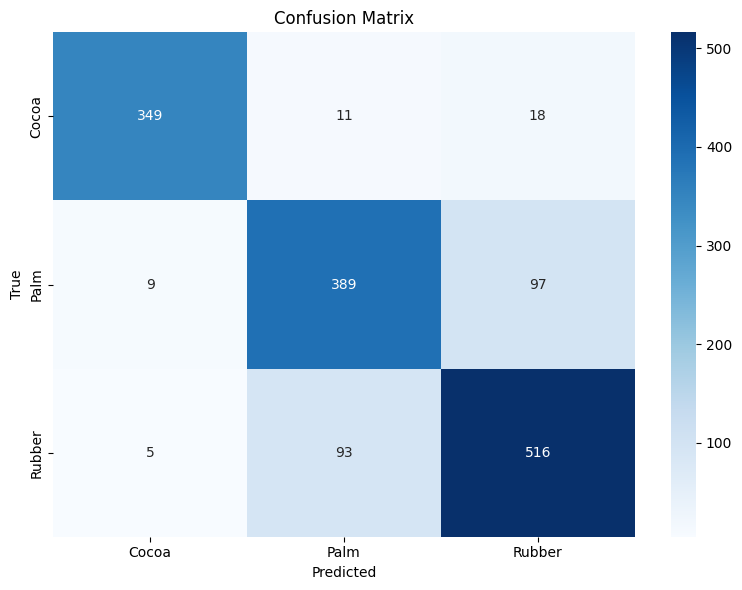

In [25]:
# Evaluate the model
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_val_scaled), axis=1)
f1 = f1_score(y_val, y_pred, average='macro')
print(f"\nValidation F1 Score (macro): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
class_names = ['Cocoa', 'Palm', 'Rubber']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Training CatBoost model...
0:	learn: 1.0727746	test: 1.0743209	best: 1.0743209 (0)	total: 347ms	remaining: 2m 53s
100:	learn: 0.5154318	test: 0.5621947	best: 0.5621947 (100)	total: 13.5s	remaining: 53.1s
200:	learn: 0.4149439	test: 0.4894751	best: 0.4894751 (200)	total: 26.1s	remaining: 38.8s
300:	learn: 0.3487254	test: 0.4481670	best: 0.4481670 (300)	total: 39.1s	remaining: 25.8s
400:	learn: 0.3003479	test: 0.4225923	best: 0.4225782 (399)	total: 52s	remaining: 12.8s
499:	learn: 0.2651006	test: 0.4069017	best: 0.4069017 (499)	total: 1m 5s	remaining: 0us

bestTest = 0.4069017429
bestIteration = 499


Validation F1 Score (macro): 0.8494

Classification Report:
              precision    recall  f1-score   support

       Cocoa       0.96      0.91      0.94       378
        Palm       0.79      0.77      0.78       495
      Rubber       0.81      0.85      0.83       614

    accuracy                           0.84      1487
   macro avg       0.85      0.85      0.85      1487
weighte

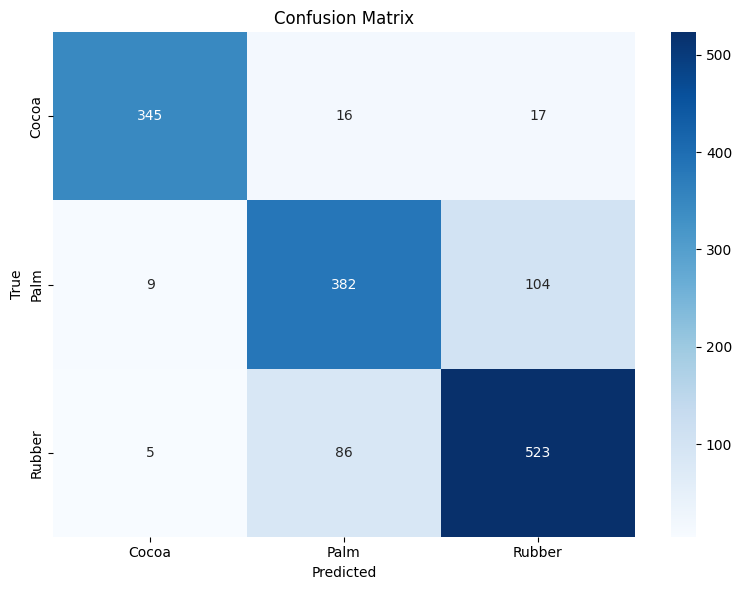

In [26]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define model
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=SEED,
    verbose=100,
    early_stopping_rounds=50
)

# Create Pool objects for CatBoost
train_pool = Pool(data=X_train_scaled, label=y_train)
val_pool = Pool(data=X_val_scaled, label=y_val)

# Train the model
print("Training CatBoost model...")
catboost_model.fit(train_pool, eval_set=val_pool)

# Predict
y_pred_probs = catboost_model.predict_proba(X_val_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate with F1 Score
f1 = f1_score(y_val, y_pred, average='macro')
print(f"\nValidation F1 Score (macro): {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Cocoa', 'Palm', 'Rubber']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
class_names = ['Cocoa', 'Palm', 'Rubber']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Training Gradient Boosting model...

Validation F1 Score (macro): 0.8645

Classification Report:
              precision    recall  f1-score   support

       Cocoa       0.96      0.94      0.95       378
        Palm       0.81      0.79      0.80       495
      Rubber       0.83      0.86      0.85       614

    accuracy                           0.86      1487
   macro avg       0.87      0.86      0.86      1487
weighted avg       0.86      0.86      0.86      1487



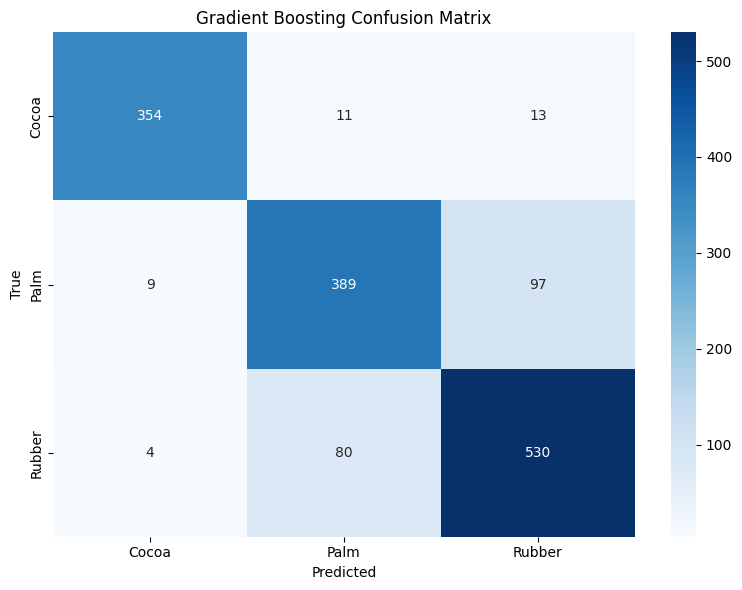

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

gb_params = {'n_estimators': 333, 'learning_rate': 0.29728232981278574, 'max_depth': 9, 
'min_samples_split': 8,'min_samples_leaf': 5, 'subsample': 0.5822537141129174, 'max_features': None}

# # Define model
# gb_model = GradientBoostingClassifier(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=8,
#     subsample=0.8,
#     random_state=SEED
# )
# Define model
gb_model = GradientBoostingClassifier(random_state=42, **gb_params)

# Train model
print("Training Gradient Boosting model...")
gb_model.fit(X_train_scaled, y_train)

# Predict
y_pred = gb_model.predict(X_val_scaled)

# Evaluate
f1 = f1_score(y_val, y_pred, average='macro')
print(f"\nValidation F1 Score (macro): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Cocoa', 'Palm', 'Rubber']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cocoa', 'Palm', 'Rubber'],
            yticklabels=['Cocoa', 'Palm', 'Rubber'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gradient Boosting Confusion Matrix')
plt.tight_layout()
plt.show()


In [28]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import f1_score
# import optuna

# def objective_gb(trial):
#     model = GradientBoostingClassifier(
#         n_estimators=trial.suggest_int('n_estimators', 100, 800),
#         learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
#         max_depth=trial.suggest_int('max_depth', 3, 12),
#         min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
#         min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
#         subsample=trial.suggest_float('subsample', 0.5, 1.0),
#         max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         random_state=SEED
#     )

#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_val_scaled)
#     score = f1_score(y_val, y_pred, average='macro')
#     return score

# study_gb = optuna.create_study(direction='maximize')
# study_gb.optimize(objective_gb, n_trials=50)

# print("Best Gradient Boosting parameters:")
# print(study_gb.best_params)
# print("Best macro F1 Score:", study_gb.best_value)


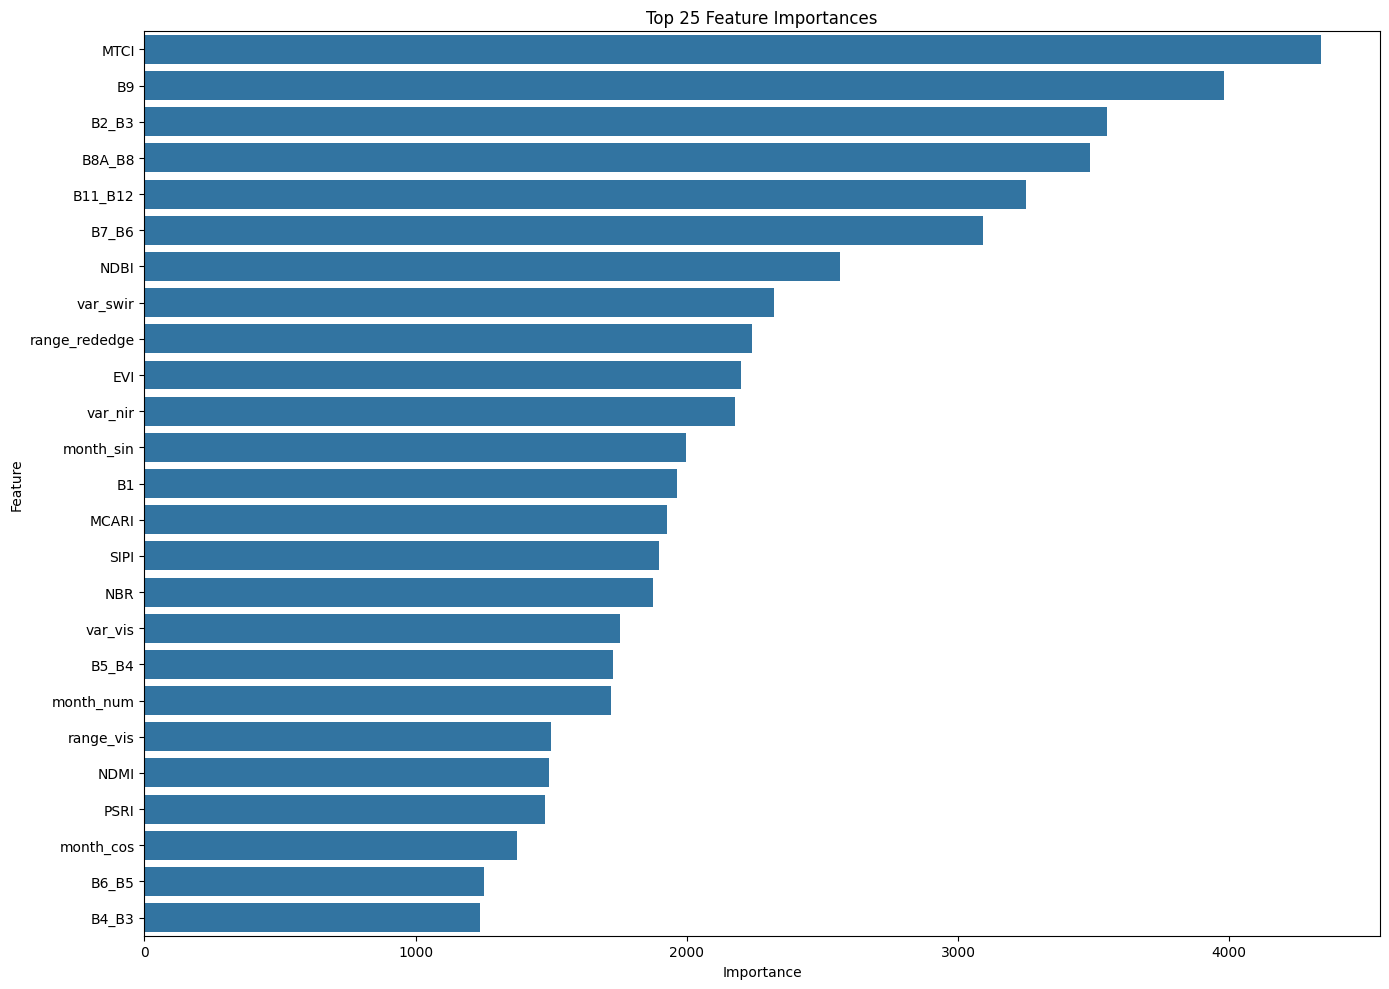

In [29]:
# Feature importance
feature_cols = X_train.columns
plt.figure(figsize=(14, 10))
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
top_features = feature_importance.head(25)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 25 Feature Importances')
plt.tight_layout()
plt.show()

In [30]:
# Train on full dataset
print("\nTraining on full dataset...")
X_full_scaled = scaler.fit_transform(X)
train_data_full = lgb.Dataset(X_full_scaled, label=y)
final_model = lgb.train(lgb_params, train_data_full, num_boost_round=model.best_iteration)


Training on full dataset...


In [ ]:
pip install autogluon --user

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached grpcio-1.71.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of datasets to determine which version is compatible with other requirements. This coul

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\janen\\AppData\\Local\\Temp\\pip-unpack-vqfcywfq\\scikit_image-0.25.2-cp311-cp311-win_amd64.whl'
Consider using the `--user` option or check the permissions.



In [36]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine train features and labels into a single DataFrame
train_df = X_train_scaled.copy()
train_df['label'] = y_train

# Define label column
label_column = 'label'

# Initialize and train AutoGluon predictor
predictor = TabularPredictor(label=label_column, eval_metric='f1_macro', verbosity=2).fit(
    train_df,
    time_limit=600,  # Optional: limit total training time (seconds)
    presets='best_quality'  # You can also try 'medium_quality_faster_train'
)

# Prepare validation set
val_df = X_val_scaled.copy()
val_df['label'] = y_val

# Predict
y_pred = predictor.predict(val_df.drop(columns=[label_column]))

# Evaluate
f1 = f1_score(y_val, y_pred, average='macro')
print(f"\nValidation F1 Score (macro): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Cocoa', 'Palm', 'Rubber']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cocoa', 'Palm', 'Rubber'],
            yticklabels=['Cocoa', 'Palm', 'Rubber'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('AutoGluon Confusion Matrix')
plt.tight_layout()
plt.show()

# Best model summary
print("\nBest Model:", predictor.get_model_best())
print("\nLeaderboard:")
print(predictor.leaderboard(val_df, silent=True))


ModuleNotFoundError: No module named 'autogluon'

In [38]:
!pip install flaml

[flaml.automl.logger: 05-19 21:51:50] {1728} INFO - task = classification
[flaml.automl.logger: 05-19 21:51:50] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-19 21:51:51] {1838} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl.logger: 05-19 21:51:51] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 05-19 21:51:51] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-19 21:51:51] {2393} INFO - Estimated sufficient time budget=7702s. Estimated necessary time budget=190s.
[flaml.automl.logger: 05-19 21:51:51] {2442} INFO -  at 0.8s,	estimator lgbm's best error=0.4753,	best estimator lgbm's best error=0.4753
[flaml.automl.logger: 05-19 21:51:51] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-19 21:51:52] {2442} INFO -  at 1.7s,	estimator lgbm's best error=0.4753,	best estimator lgbm's best error=0.4753
[flaml.automl.

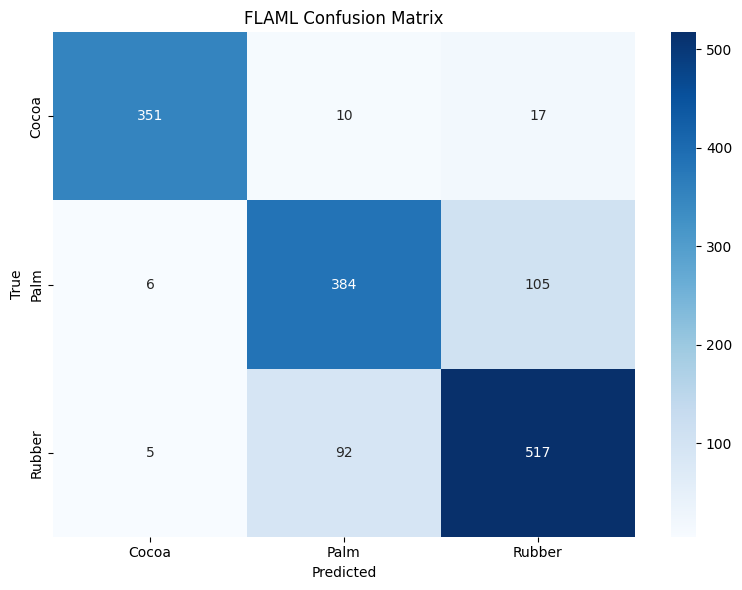


Best FLAML model: LGBMClassifier(colsample_bytree=0.8624846715013416,
               learning_rate=0.3586109467718728, max_bin=31,
               min_child_samples=16, n_estimators=400, n_jobs=-1, num_leaves=9,
               reg_alpha=0.023672286951833103, reg_lambda=6.93728258663551,
               verbose=-1)
Best FLAML hyperparameters: {'n_estimators': 400, 'num_leaves': 9, 'min_child_samples': 16, 'learning_rate': 0.3586109467718728, 'log_max_bin': 5, 'colsample_bytree': 0.8624846715013416, 'reg_alpha': 0.023672286951833103, 'reg_lambda': 6.93728258663551}


In [39]:
from flaml import AutoML
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize AutoML
automl = AutoML()

# Set settings
automl_settings = {
    "time_budget": 600,  # seconds
    "metric": 'macro_f1',
    "task": 'classification',
    "log_file_name": "flaml_classification.log",
    "seed": 42
}

# Train AutoML
automl.fit(X_train=X_train_scaled, y_train=y_train, **automl_settings)

# Predict
y_pred = automl.predict(X_val_scaled)

# Evaluate
f1 = f1_score(y_val, y_pred, average='macro')
print(f"\n[FLAML] Validation F1 Score (macro): {f1:.4f}")
print("\n[FLAML] Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Cocoa', 'Palm', 'Rubber']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cocoa', 'Palm', 'Rubber'],
            yticklabels=['Cocoa', 'Palm', 'Rubber'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('FLAML Confusion Matrix')
plt.tight_layout()
plt.show()

# Best model and config
print("\nBest FLAML model:", automl.model.estimator)
print("Best FLAML hyperparameters:", automl.best_config)


In [42]:
!pip install h2o  --user

  Using cached h2o-3.46.0.7-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   --------------

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\janen\\AppData\\Local\\Temp\\pip-unpack-7qqjz3f4\\h2o-3.46.0.7-py2.py3-none-any.whl'
Check the permissions.



In [43]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Start H2O cluster
h2o.init()

# Combine train and val sets
train_df = X_train_scaled.copy()
train_df['label'] = y_train
val_df = X_val_scaled.copy()
val_df['label'] = y_val

# Convert to H2OFrame
h2o_train = h2o.H2OFrame(train_df)
h2o_val = h2o.H2OFrame(val_df)

# Set column types
h2o_train['label'] = h2o_train['label'].asfactor()
h2o_val['label'] = h2o_val['label'].asfactor()

# Run AutoML
aml = H2OAutoML(max_models=20, seed=42, sort_metric='mean_per_class_error')  # or sort_metric='mean_per_class_f1'
aml.train(y='label', training_frame=h2o_train)

# Predict
preds = aml.leader.predict(h2o_val).as_data_frame()['predict'].astype(int)

# Evaluate
f1 = f1_score(y_val, preds, average='macro')
print(f"\n[H2O] Validation F1 Score (macro): {f1:.4f}")
print("\n[H2O] Classification Report:")
print(classification_report(y_val, preds, target_names=['Cocoa', 'Palm', 'Rubber']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cocoa', 'Palm', 'Rubber'],
            yticklabels=['Cocoa', 'Palm', 'Rubber'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('H2O AutoML Confusion Matrix')
plt.tight_layout()
plt.show()

# Best model
print("\nBest H2O Model:", aml.leader.model_id)


ModuleNotFoundError: No module named 'h2o'

### Hyperparameter Tuning

In [ ]:
# # Lets do the CV
# from sklearn.model_selection import StratifiedKFold

# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Store metrics
# f1_scores = []
# thresholds_per_class = []
# all_val_preds = []
# all_val_true = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     print(f"\n--- Fold {fold + 1} ---")

#     X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#     X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

#     sample_weights = np.array([class_weights_dict[label] for label in y_train])

#     dtrain = lgb.Dataset(X_train, label=y_train, weight=sample_weights)
#     dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

#     model = lgb.train(
#         params=lgb_params,
#         train_set=dtrain,
#         num_boost_round=1000,
#         valid_sets=[dtrain, dval],
#         valid_names=['train', 'valid'],
#         callbacks=[lgb.early_stopping(stopping_rounds=100)]
#     )

#     val_probs = model.predict(X_val, num_iteration=model.best_iteration)

#     best_thresholds = [0.5] * 3
#     best_f1 = 0

#     # Optimize threshold per class
#     for t0 in np.arange(0.1, 0.9, 0.05):
#         for t1 in np.arange(0.1, 0.9, 0.05):
#             for t2 in np.arange(0.1, 0.9, 0.05):
#                 thresholds = [t0, t1, t2]
#                 val_preds = []
#                 for probs in val_probs:
#                     pred = np.argmax([probs[0] > t0, probs[1] > t1, probs[2] > t2])
#                     val_preds.append(pred)

#                 f1 = f1_score(y_val, val_preds, average='macro')
#                 if f1 > best_f1:
#                     best_f1 = f1
#                     best_thresholds = thresholds

#     print(f"Fold {fold + 1} Best Thresholds: {best_thresholds}")
#     print(f"Fold {fold + 1} F1 Score: {best_f1:.4f}")

#     # Final predictions with best thresholds
#     final_preds = []
#     for probs in val_probs:
#         pred = np.argmax([probs[0] > best_thresholds[0], probs[1] > best_thresholds[1], probs[2] > best_thresholds[2]])
#         final_preds.append(pred)

#     thresholds_per_class.append(best_thresholds)
#     f1_scores.append(best_f1)
#     all_val_preds.extend(final_preds)
#     all_val_true.extend(y_val)

# # Final cross-validated results
# print("\n=== Cross-Validation Results ===")
# print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
# print(f"Average Best Thresholds: {np.mean(thresholds_per_class, axis=0)}")

# print("\nClassification Report:")
# print(classification_report(all_val_true, all_val_preds))

# print("Confusion Matrix:")
# cm = confusion_matrix(all_val_true, all_val_preds)
# print(cm)

# # Plot confusion matrix
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

### Submission

In [31]:
test_df = test_features_df.copy()
test_preds = final_model.predict(X_test_scaled)
test_df['prediction'] = np.argmax(test_preds, axis=1)
test_df['prediction_label'] = test_df['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})
test_df.head()

,ID,month,B1,B2,B3,B4,B5,B6,B7,B8,...,range_vis,range_nir,range_swir,range_rededge,month_sin,month_cos,season,growth_phase,prediction,prediction_label
0,ID_731818_Jan,Jan,3065.4858,2848.5762,2737.4430,2650.5790,2782.1729,3667.0303,4166.7627,3923.6260,...,197.9972,555.7570,890.9043,1384.5898,0.5,0.866025,2,4,1,Palm
1,ID_790093_Jan,Jan,2621.2246,2309.7244,2110.1357,1875.1238,1988.7589,2700.0068,3054.5881,2864.1042,...,434.6006,370.6358,600.8485,1065.8292,0.5,0.866025,2,4,1,Palm
2,ID_601980_Jan,Jan,2659.6480,2354.0280,2203.0790,1984.5513,2193.3170,3186.1792,3684.4888,3500.9580,...,369.4767,517.5557,944.8504,1491.1718,0.5,0.866025,2,4,1,Palm
3,ID_094903_Jan,Jan,2540.3206,2252.0515,2103.8455,1871.3022,2125.5632,3142.3088,3642.0835,3462.3076,...,380.7493,524.8609,1044.3587,1516.5203,0.5,0.866025,2,4,2,Rubber
4,ID_691532_Jan,Jan,2507.0132,2213.9631,2045.4926,1812.7167,2008.9689,2857.1953,3268.1907,3099.5610,...,401.2464,432.4532,845.4738,1259.2218,0.5,0.866025,2,4,2,Rubber


In [32]:
# Get prediction probabilities
test_df['prob_cocoa'] = test_preds[:, 0]
test_df['prob_palm'] = test_preds[:, 1]
test_df['prob_rubber'] = test_preds[:, 2]

# Aggregate predictions by base_id using most frequent prediction
test_df['base_id'] = test_df['ID'].str.split('_').str[1]

agg_most_frequent = test_df.groupby('base_id')['prediction_label'].agg(
    lambda x: x.value_counts().index[0]
).reset_index()

In [33]:
# Create submission file
submission = pd.DataFrame({
    'ID': 'ID_' + agg_most_frequent['base_id'],
    'Target': agg_most_frequent['prediction_label']
})

print(submission['Target'].value_counts())
print()
print(f"Final submission shape: {submission.shape}")
submission.to_csv('byte_sized_submission.csv', index=False)

Target
Rubber    122
Palm      115
Cocoa      45
Name: count, dtype: int64

Final submission shape: (282, 2)
